In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bsd_dataset import get_dataset, regions, DatasetRequest
import bsd_dataset.common.metrics as metrics
import bsd_dataset.common.transforms as transforms
from bsd_dataset.datasets.check_dataset import Interpolator

import torch

/home/jason.jewik/miniconda3/envs/downscale-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
variable = [
    'daily_maximum_near_surface_air_temperature',
    'daily_minimum_near_surface_air_temperature',
    'near_surface_air_temperature',
    'near_surface_specific_humidity',
    'near_surface_wind_speed',
    'precipitation',
    'sea_level_pressure'
]

input_datasets = [
    DatasetRequest(
        dataset='projections-cmip6',
        model='gfdl_esm4',
        variable=variable
    )
]

target_dataset = DatasetRequest(dataset='chirps', resolution=0.25)

root = f'/home/data/BSDD/experiment-2.1'
study_region = regions.SouthAmerica

In [27]:
dataset = get_dataset(
    input_datasets,
    target_dataset,
    train_region=study_region,
    val_region=study_region,
    test_region=study_region,
    train_dates=('1983-01-01', '2010-12-31'),
    val_dates=('2011-01-01', '2012-12-31'),
    test_dates=('2013-01-01', '2014-12-31'),
    download=False,
    extract=False, 
    root=root
)

In [28]:
# In CDS, precipitation's variable name is "pr"
transform = transforms.ConvertPrecipitation(var_name='pr')
test_dataset = dataset.get_split('test', transform)

In [29]:
# Create an interpolator, which downsamples the hi-res target to the low-res input
metrics_dict = {'rmse': metrics.rmse, 'bias': metrics.abs_bias, 'pearsons_r': metrics.pearsons_r}
interp = Interpolator(metrics_dict)

In [45]:
# Then we want to see how the downsampled hi-res targets compare against the low-res inputs
running = torch.tensor([0., 0., 0.])

for i, (x, y, info) in enumerate(test_dataset):
    xx = interp(x[5:6], y, info)
    # channel 5 is the precipitation channel for this particular dataset
    results = interp.eval(xx, x[5], info['y_mask'])
    running += torch.tensor(list(results.values()))
    
running /= (torch.ones_like(running) * i)
for metric_name, val in zip(metrics_dict.keys(), running.tolist()):
    print(f'Average {metric_name}: {val}')

Average rmse: 1.22656456369441e-06
Average bias: 3.61650933200508e-07
Average pearsons_r: 1.0013717412948608


In [24]:
import matplotlib.pyplot as plt

(array([[31.,  0.,  0., ...,  0.,  0.,  0.],
        [33.,  0.,  0., ...,  0.,  0.,  0.],
        [32.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [28.,  0.,  0., ...,  0.,  0.,  0.],
        [27.,  0.,  0., ...,  0.,  0.,  0.],
        [29.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.      ,  10.490751,  20.981503,  31.472256,  41.963005,
         52.45376 ,  62.94451 ,  73.435265,  83.92601 ,  94.41676 ,
        104.90752 ], dtype=float32),
 <a list of 280 BarContainer objects>)

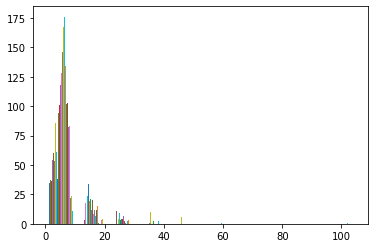

In [25]:
plt.hist(y)